## Import packages

In [ ]:
import os
import numpy as np
import tensorflow as tf
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, concatenate
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers

## Data Preparation for Road Extraction from Satellite Images

In [ ]:
# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define your folder where the images and masks are stored
train_dir = 'dataset/train'

# Create a list of image file paths and corresponding mask file paths
image_paths = sorted([os.path.join(train_dir, f) for f in os.listdir(train_dir) if '_sat' in f])  # Satellite images
mask_paths = sorted([os.path.join(train_dir, f) for f in os.listdir(train_dir) if '_mask' in f])  # Mask images

# Create a DataFrame
df = pd.DataFrame({
    'filename': image_paths,
    'mask': mask_paths
})

In [ ]:
# Sample 10% of the training and validation dataset
train_df_sampled = train_df.sample(frac=0.1, random_state=42)
val_df_sampled = val_df.sample(frac=0.1, random_state=42)

## Image and Mask Augmentation for Road Extraction

In [ ]:
# Define ImageDataGenerator for augmentation (both for images and masks)
data_gen_args = dict(rotation_range=30,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')

# ImageDataGenerator instances for images and masks
image_datagen = ImageDataGenerator(rescale=1./255, **data_gen_args)
mask_datagen = ImageDataGenerator(rescale=1./255)

# Load images from DataFrame
image_generator = image_datagen.flow_from_dataframe(
    train_df_sampled,  
    x_col='filename',
    target_size=(128, 128),
    class_mode=None,
    batch_size=8,  
    seed=42)

# Load masks from DataFrame
mask_generator = mask_datagen.flow_from_dataframe(
    train_df_sampled,  
    x_col='mask',
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode=None,
    batch_size=8,  
    seed=42)

# Validation generators with 10% of the dataset
val_image_generator = image_datagen.flow_from_dataframe(
    val_df_sampled,  
    x_col='filename',
    target_size=(128, 128),
    class_mode=None,
    batch_size=8,
    seed=42)

val_mask_generator = mask_datagen.flow_from_dataframe(
    val_df_sampled,  
    x_col='mask',
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode=None,
    batch_size=8,
    seed=42)

### Custom Data Generator for Paired Image and Mask Batches

In [ ]:
# Custom data generator
def custom_data_generator(image_generator, mask_generator):
    while True:
        image_batch = next(image_generator)
        mask_batch = next(mask_generator)
        yield (image_batch, mask_batch)

# Combine image and mask generators for training and validation
train_generator = custom_data_generator(image_generator, mask_generator)
val_generator = custom_data_generator(val_image_generator, val_mask_generator)

In [ ]:
# Implementing DeepLabV3+ manually
def DeeplabV3Plus(input_shape=(128, 128, 3), num_classes=1):
    # Backbone with ResNet50
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

    # Atrous Spatial Pyramid Pooling (ASPP)
    b4 = layers.GlobalAveragePooling2D()(base_model.output)
    b4 = layers.Reshape((1, 1, -1))(b4)
    b4 = layers.Conv2D(256, 1, padding="same")(b4)
    b4 = layers.UpSampling2D((32, 32), interpolation="bilinear")(b4)

    # Convolution layers with different dilation rates (6, 12, 18)
    b0 = layers.Conv2D(256, 1, padding="same")(base_model.output)
    b0 = layers.UpSampling2D((8, 8), interpolation="bilinear")(b0)  # Upsample to 32x32

    b1 = layers.Conv2D(256, 3, dilation_rate=6, padding="same")(base_model.output)
    b1 = layers.UpSampling2D((8, 8), interpolation="bilinear")(b1)  # Upsample to 32x32

    b2 = layers.Conv2D(256, 3, dilation_rate=12, padding="same")(base_model.output)
    b2 = layers.UpSampling2D((8, 8), interpolation="bilinear")(b2)  # Upsample to 32x32

    b3 = layers.Conv2D(256, 3, dilation_rate=18, padding="same")(base_model.output)
    b3 = layers.UpSampling2D((8, 8), interpolation="bilinear")(b3)  # Upsample to 32x32

    # Concatenate all the layers
    x = layers.Concatenate()([b4, b0, b1, b2, b3])
    x = layers.Conv2D(256, 1, padding="same")(x)

    # Decoder - Correct the upsampling to match the input size of 128x128
    x = layers.UpSampling2D((4, 4), interpolation="bilinear")(x)  # This will make the output 128x128
    x = layers.Conv2D(256, 3, padding="same")(x)
    x = layers.Conv2D(num_classes, (1, 1), padding="same", activation="sigmoid")(x)  # Final layer with sigmoid

    model = Model(inputs=base_model.input, outputs=x)
    return model


In [ ]:
# Build and compile the model
model = DeeplabV3Plus(input_shape=(128, 128, 3), num_classes=1)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


In [5]:
# Set up steps per epoch
steps_per_epoch = len(image_generator)

# Callbacks
checkpoint_cb = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss", mode='min')
early_stopping_cb = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# To calculate and display epoch time and total training time
start_training_time = time.time()

# Train the model with time estimation
for epoch in range(10):
    start_time = time.time()  # Start time for the current epoch
    
    # Training step
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,  # Number of batches per epoch
        epochs=1,  # Train one epoch at a time
        callbacks=[checkpoint_cb, early_stopping_cb],
        validation_data=val_generator,
        validation_steps=len(val_image_generator)  # Number of validation steps per epoch
    )
    
    # Time taken for the current epoch
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1}/50 completed in {epoch_time:.2f} seconds.")
    
    # Estimate total training time based on the average epoch time so far
    elapsed_training_time = time.time() - start_training_time
    avg_epoch_time = elapsed_training_time / (epoch + 1)
    remaining_epochs = 50 - (epoch + 1)
    estimated_remaining_time = avg_epoch_time * remaining_epochs
    
    print(f"Estimated remaining time: {estimated_remaining_time:.2f} seconds.")
    
    # Early stop if training stops
    if early_stopping_cb.stopped_epoch > 0:
        print(f"Training stopped early at epoch {early_stopping_cb.stopped_epoch}.")
        break

# Save the final model
model.save("deeplabv3_road_segmentation.keras")

# Evaluate the model
test_loss, test_accuracy = model.evaluate(val_generator, steps=len(val_image_generator))
print(f"Validation loss: {test_loss}, Validation accuracy: {test_accuracy}")

# Print total training time
total_training_time = time.time() - start_training_time
print(f"Total training time: {total_training_time:.2f} seconds.")


Found 498 validated image filenames.
Found 498 validated image filenames.
Found 125 validated image filenames.
Found 125 validated image filenames.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 39,711,617 (151.49 MB)

 Trainable params: 39,658,497 (151.29 MB)

 Non-trainable params: 53,120 (207.50 KB)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2800s 44s/step - accuracy: 0.9094 - loss: 0.3810 - val_accuracy: 0.9617 - val_loss: 0.2655
Epoch 1/50 completed in 2802.34 seconds.
Estimated remaining time: 137314.77 seconds.
63/63 ━━━━━━━━━━━━━━━━━━━━ 3650s 58s/step - accuracy: 0.9589 - loss: 0.1703 - val_accuracy: 0.9610 - val_loss: 0.7625
Epoch 2/50 completed in 3651.85 seconds.
Estimated remaining time: 154900.62 seconds.
13/63 ━━━━━━━━━━━━━━━━━━━━ 1:01:55 74s/step - accuracy: 0.9669 - loss: 0.1444

KeyboardInterrupt: 

In [62]:
# Evaluate the model after the first epoch on the validation set
eval_results = model_first_epoch.evaluate(val_generator, steps=len(val_image_generator))

print(f"Validation Loss after 1st Epoch: {eval_results[0]:.4f}")
print(f"Validation Accuracy after 1st Epoch: {eval_results[1]:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 87s 5s/step - accuracy: 0.9610 - loss: 0.3506
Validation Loss after 1st Epoch: 0.3405
Validation Accuracy after 1st Epoch: 0.9623


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


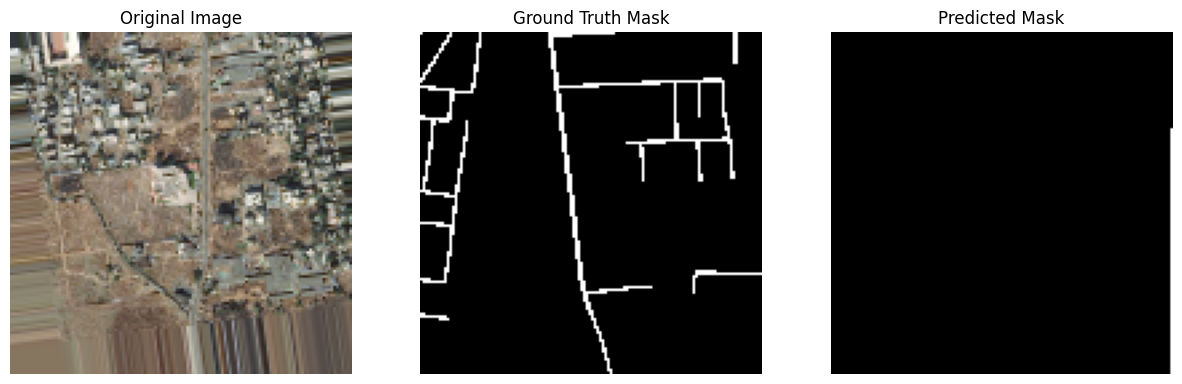

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


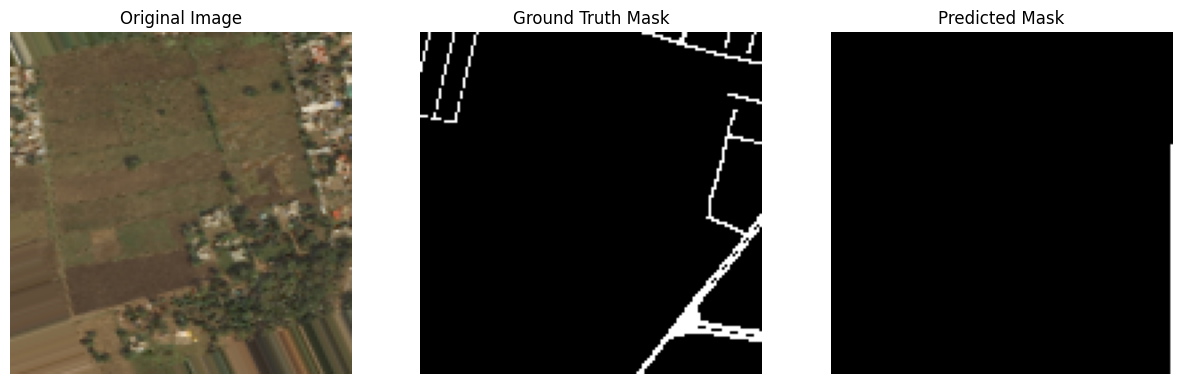

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


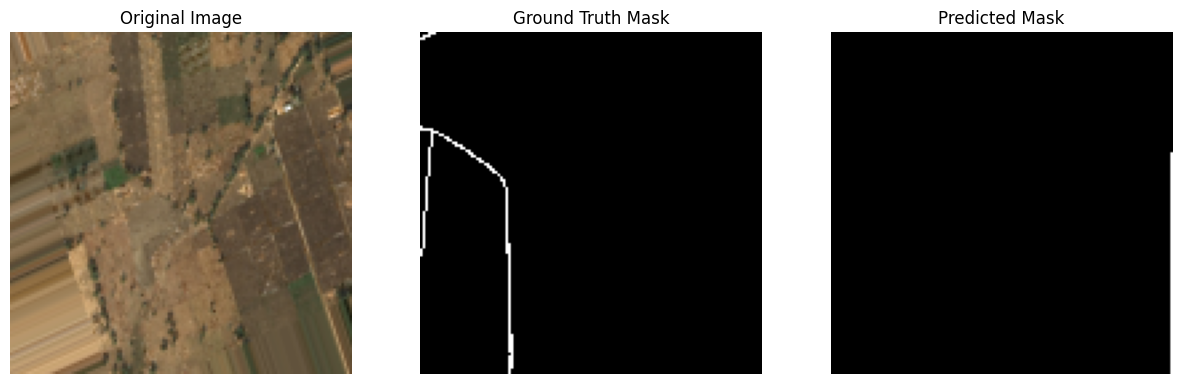

KeyboardInterrupt: 

In [50]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Get 10 random batches from the validation generator
for i in range(10):
    # Retrieve the next batch from the validation generator
    img_batch, mask_batch = next(val_generator)
    
    # Predict the mask for the batch
    pred_mask_batch = model.predict(img_batch)
    
    # Apply thresholding to get binary predictions
    pred_mask_batch = (pred_mask_batch > 0.5).astype(np.uint8)

    # Visualize the original image, ground truth mask, and predicted mask
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    # Show original image
    ax[0].imshow(img_batch[0])
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    # Show ground truth mask
    ax[1].imshow(mask_batch[0].squeeze(), cmap='gray')  # Squeeze to remove channel dimension
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')
    
    # Show predicted mask
    ax[2].imshow(pred_mask_batch[0].squeeze(), cmap='gray')
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')

    plt.show()
